# Packages

In [1]:
!pip install calplot
!pip install plotly-calplot
!pip install july

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import date
import sqlite3
from datetime import timedelta
from plotly_calplot import calplot # optional visual heatmap
import calplot # optional visual heatmap
import july # optional visual heatmap
from july.utils import date_range
%matplotlib inline

# API Extraction

In [3]:
website = 'https://calendarific.com/api/v2/'
key = 'e937c7c03d3e9293144395a1ce4c958168b155f1' #insert your own API here
parameter = "holidays"
country_api = "za" #choose countries here


year_start = int(datetime.datetime.now().date().strftime("%Y"))
interval = 5 #yrs
year_end = year_start+interval #Assumes a 5 year interval

'''
year_period = list of years
Adding another for the following reasons:

 Other year is added to get the possible leave deductions
 for the final December days as the leave interval potentially 
 rolls over into the new year

e.g. 
year_end = 2022

date = 2022-12-29
Leave interval = 5

You will need check the days from 2022-12-29 to 2023-01-02
to see if there are any potential annual leave deductions

'''
year_period = [x for x in range(year_start, year_end+1)]

print(year_period)


[2022, 2023, 2024, 2025, 2026, 2027]


# PANDAS DATAFRAMES

Creating two pandas dataframes

1. all South African holidays
2. all the dates within the specified period


In [4]:
#Lists for dataframe
calender = [] #calender date
name = [] #holiday name
holiday_type = [] #public holiday/observaence/
# country = []
description = [] #info

def holiday_data(year_period):

  """
  Functions takes data from website and adds to lists
  """

  for year in year_period: #extracts data for each year from API

    #full api key using parameters from above
    api = f"{website}{parameter}&?api_key={key}&country={country_api}&year={year}"
    response = requests.get(api)
    
    data = response.json()

    #transform data from json file making easier to work with
    holidays = data['response']['holidays']
    holidays[0]

    for i in range(len(holidays)): #adds to list

      calender.append(holidays[i]['date']["iso"][:10])
      name.append(holidays[i]['name'])
      holiday_type.append((holidays[i]["type"][0]))
      # country.append(holidays[i]["country"]["id"])
      description.append(holidays[i]["description"])

    check = calender[-1]
    print(check)

  return print("Lists Created")

holiday_data(year_period)

2022-12-31
2023-12-31
2024-12-31
2025-12-31
2026-12-31
2027-12-31
Lists Created


## National Holiday Dataframe

In [5]:
def pandas_df(calender, name, holiday_type, desc):
  """
  Function creates data frame of holidays
  """

  #create dataframe using lists
  df = pd.DataFrame({
              "date": calender, 
              "name": name,
              "type":holiday_type,
                # "country": country,
                "description" : desc
                })
  
  from datetime import date 

  #adding day name to dataframe
  df.insert(1,"weekday", pd.to_datetime(calender, format = "%Y-%m-%d").strftime("%A"))

  #filters data showing only holidays after current date
  current = str(date.today())
  # df = df[df["date"] >= current]

  return df 

#call out dataframe
df = pandas_df(calender, name, holiday_type, description)
df.head()

,date,weekday,name,type,description
0,2022-01-01,Saturday,New Year's Day,National holiday,New Year’s Day is celebrated with a blend of b...
1,2022-03-01,Tuesday,Isra and Mi'raj,Muslim,"Isra and Mi'raj (Isra Me'raj, Israa and Mi'raa..."
2,2022-03-20,Sunday,March Equinox,Season,March Equinox in South Africa (Johannesburg)
3,2022-03-21,Monday,Human Rights Day,National holiday,Human Rights Day is a public holiday in South ...
4,2022-04-15,Friday,Good Friday,National holiday,Good Friday is a global Christian observance t...


## Calender Datatable

Basically a pandas df of all the dates from the last time the script was ran to the end of the chosen year

In [6]:
def create_datetable(year_start, year_end): 
  '''
  Function creates dataframe for all days within 
  period which contains the following data:
  1. Date 
  2. Day name
  3. type of day: weekday or weekend
  '''

  begin = f"{year_start}-01-01"
  end = f"{year_end}-12-31"
  df_days = pd.DataFrame({"date": pd.date_range(begin, end)})
  df_days['weekday'] = df_days['date'].dt.day_name()

  day_type = []

  for weekno in df_days["date"]:

    weekno = weekno.weekday()

    #weekdays index values is 0,1,2,3,4
    if weekno < 5:
      day_type.append("Weekday")
    else:  
        # 5 Sat, 6 Sun
      day_type.append("Weekend")

  df_days["weekday_type"] = day_type

  #Converts date column type to string
  df_days["date"] = df_days["date"].astype(str)

  return df_days

df_days = create_datetable(year_start, year_end)
df_days.head()

print(df_days.info())
print(df_days.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          2191 non-null   object
 1   weekday       2191 non-null   object
 2   weekday_type  2191 non-null   object
dtypes: object(3)
memory usage: 51.5+ KB
None
         date    weekday weekday_type
0  2022-01-01   Saturday      Weekend
1  2022-01-02     Sunday      Weekend
2  2022-01-03     Monday      Weekday
3  2022-01-04    Tuesday      Weekday
4  2022-01-05  Wednesday      Weekday


# SQL Database

converts the two pandas dataframes into sql databases

## National SQL holiday database

In [7]:
# Creates database 
#Creates holiday date database

conn = sqlite3.connect('test_database')
c = conn.cursor()

c.execute('''CREATE TABLE IF NOT EXISTS holiday ( 
          date text, 
          weekday text, 
          name text,
          type text)
          ''')
conn.commit()

df.to_sql('holiday', conn, if_exists='replace', index = False)

c.execute('''  
SELECT * FROM holiday
          ''')

c.execute('''
          SELECT *
          FROM holiday
          ''')

holidays = c.fetchall()

for holiday in holidays[:5]:
  print(holiday)


('2022-01-01', 'Saturday', "New Year's Day", 'National holiday', 'New Year’s Day is celebrated with a blend of both diversity and tradition in countries such as South Africa on January 1 each year.')
('2022-03-01', 'Tuesday', "Isra and Mi'raj", 'Muslim', "Isra and Mi'raj (Isra Me'raj, Israa and Mi'raaj, Laylat Al-Isra wa Al-Miraj, Lailat al Miraj, Night Journey and Ascension to Heaven) marks the night that the Prophet Mohammad traveled from Mecca to Jerusalem, ascended to heaven and returned.")
('2022-03-20', 'Sunday', 'March Equinox', 'Season', 'March Equinox in South Africa (Johannesburg)')
('2022-03-21', 'Monday', 'Human Rights Day', 'National holiday', 'Human Rights Day is a public holiday in South Africa')
('2022-04-15', 'Friday', 'Good Friday', 'National holiday', 'Good Friday is a global Christian observance two days before Easter Sunday.')


## Calender SQL database

In [8]:
#Creates calender date database

df_days.to_sql('datetable', conn, if_exists='replace', index = False)

c.execute('''
          SELECT *
          FROM datetable
          ''')

calender_days = c.fetchall()

for days in calender_days[:5]:
  print(days)

('2022-01-01', 'Saturday', 'Weekend')
('2022-01-02', 'Sunday', 'Weekend')
('2022-01-03', 'Monday', 'Weekday')
('2022-01-04', 'Tuesday', 'Weekday')
('2022-01-05', 'Wednesday', 'Weekday')


### Finding National holidays occuring on Sundays
Extraction below shows all the holidays which occur on a Sunday. These holidays will occur on the nearest Monday 

In [9]:
c.execute('''
          SELECT date, weekday, name
          FROM holiday
          WHERE weekday = "Sunday"
          AND type = "National holiday"
          ''')

calender_days = c.fetchall()

for days in calender_days:
  print(days)

('2022-05-01', 'Sunday', "Workers' Day")
('2022-12-25', 'Sunday', 'Christmas Day')
('2023-01-01', 'Sunday', "New Year's Day")
('2023-09-24', 'Sunday', 'Heritage Day')
('2024-06-16', 'Sunday', 'Youth Day')
('2025-04-27', 'Sunday', 'Freedom Day')
('2026-08-09', 'Sunday', "National Women's Day")
('2027-03-21', 'Sunday', 'Human Rights Day')
('2027-12-26', 'Sunday', 'Day of Goodwill')


### Finding holidays that occur on the same day

This can occur when there is a holiday on a Sunday which will be shifted to Monday and another holiday which occurs on Monday. 

In [10]:
c.execute('''
          SELECT date, name
          FROM holiday
          WHERE date = ( SELECT date FROM holiday
          WHERE type = "National holiday"
          GROUP BY date
          HAVING COUNT(date) > 1)

           ''')

calender_days = c.fetchall()

for days in calender_days:
   print(days)

('2022-12-26', 'Christmas Day observed')
('2022-12-26', 'Day of Goodwill')


# EDA

## Total Number of Weekday Holidays

In [11]:
c.execute('''
          SELECT *
          FROM holiday
          WHERE weekday = "Weekend"
          ''')
calender_days = c.fetchall()

for days in calender_days[:5]:
  print(days)

Text(0.5, 1.0, 'Total no. of weekday national holidays in South Africa for each year')

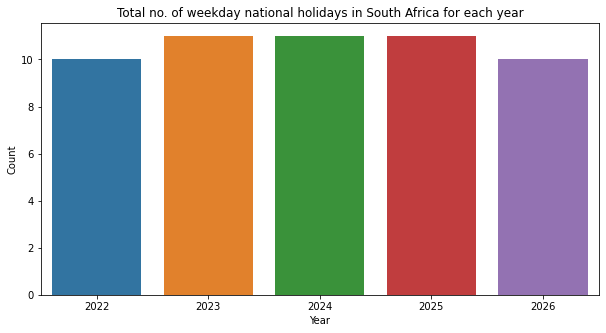

In [12]:
# This checks which year has the most holidays

#Req for dataframe
holiday_years = []
holiday_years_count = []

for year in year_period:

  c.execute('''
            SELECT date, weekday, name
            FROM holiday
            WHERE type = "National holiday"
            AND weekday != "Sunday"
            AND weekday != "Saturday"
            AND date LIKE ?
            ''',(str(year)+"%",)          
            )

  holidays = c.fetchall()

  holiday_years.append(year)
  holiday_years_count.append(len(holidays))

ax = plt.figure(figsize=(10, 5))

df_holiday_all = pd.DataFrame({"Year" : holiday_years,
                              "Count" : holiday_years_count,
                              })

df_holiday_all = df_holiday_all[df_holiday_all["Year"] < year_end]

ax = sns.barplot(data = df_holiday_all, x = "Year", y = "Count")
ax.set_title("Total no. of weekday national holidays in South Africa for each year")


Above graph shows total number of weekday national holidays in South Africa for the next decade. Generally, the current year will have the least amount of weekday holidays as the script searches for all the holidays using the script's latest run date as the beginning date. 

That aside, weekday public holidays range is between 10-11 for the next 5 years.
Reasons for the difference in holiday count may be due to  some national holidays occuring on a Saturday. These national holidays are not celebrated on the nearest Monday (Unlike national holidays that occur on Sunday) and therefore does not count as a weekday holiday. 

Text(0.5, 1.0, 'Total no. of weekday national holidays in South Africa for each year excl. Dec. holidays')

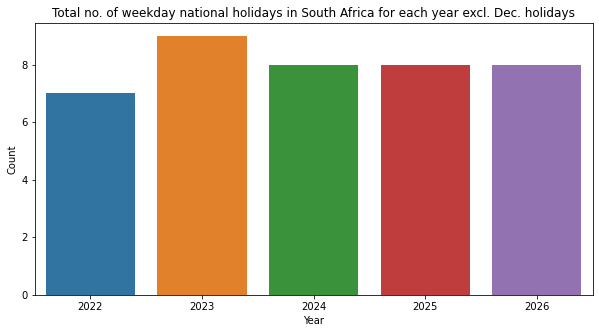

In [13]:
# This check which year has the most holidays
# Exluding the December holidays

#Req for dataframe
holiday_years_nodec = []
holiday_years_count_nodec = []

for year in year_period:

  c.execute('''
            SELECT date, weekday, name
            FROM holiday
            WHERE type = "National holiday"
            AND weekday != "Saturday"
            AND weekday != "Sunday"
            AND date LIKE ?
            AND date NOT LIKE "%-12-%"
            ''', (str(year)+"%",)
            )           

  holidays_nodec = c.fetchall()

  holiday_years_nodec.append(year)
  holiday_years_count_nodec.append(len(holidays_nodec))

df_holiday_nodec = pd.DataFrame({"Year" : holiday_years_nodec,
                              "Count" : holiday_years_count_nodec,
                              })

df_holiday_nodec = df_holiday_nodec[df_holiday_nodec["Year"] < year_end]

ax = plt.figure(figsize=(10, 5))

ax = sns.barplot(data = df_holiday_nodec, x = "Year", y = "Count")
ax.set_title("Total no. of weekday national holidays in South Africa for each year excl. Dec. holidays")

Many employees are required to take compulsory leave in December anyway. Therefore, I made a graph which shows total number of weekday national holidays in South Africa for the next decade. As mentioned previously, the current year will generally have the least amount of weekday holidays. 

The weekday public holiday range is 8-9 days for the next 10 years which relatively minimal.


## Annual leave use optimisation

Finding out which day an employee should begin there leave so that they use the least amount of annual leave days for a given period. 

Generally, employees will use two strategies:
1. Have their leave period overlap a weekend. 
2. Have their leave period over a national public hoiday

Best approach is for the leave period to have both of these strategies.

Note when looking at a date block, it shows the total annual leave required for the respective leave period. the subject date block is inclusive within the leave period.


### Only Weekends

Three leave periods were considered:

1. 3-day leave period
2. 5 day leave period

In [14]:
def weekends_only(day):

  # #functions used for determining 
  annual_leave_period = day # days
  
  #For dataframe
  total_cnt = []

  first_day = f"{year_start}-01-01"
  last_day = f"{year_end}-12-31"
  last_day = datetime.datetime.strptime(last_day, '%Y-%m-%d').date()

  #Create dataframe
  df = pd.DataFrame({"date": pd.date_range(first_day, last_day)})

  for date in df["date"].astype(str):

    #convert date into datetime format
    date = datetime.datetime.strptime(date, '%Y-%m-%d').date()

    interval_end_day = date  + timedelta(days = annual_leave_period-1)

    if  interval_end_day <= last_day:

      c.execute('''
                SELECT DISTINCT datetable.date, datetable.weekday
                FROM datetable
                LEFT JOIN holiday
                ON datetable.date = holiday.date
                WHERE datetable.date BETWEEN ? and ?
                AND datetable.weekday_type = "Weekend"                              
                ''',(str(date), str(interval_end_day),))
      
      a = c.fetchall()
      
      total_cnt.append(day-len(a))

    else:
      '''
      Req. so lists are same length
      But won't count cause we will be shortening it later
      '''
      total_cnt.append(0)

  #Adds to dataframe
  df['Count'] = total_cnt

  #Cuts out one year
  df = df[df["date"].astype(str) < str(year_end)]

  # Prep for graph 
  events = pd.Series(df[df.columns[1]].tolist(), index=df["date"])

  #plot graph
  fig = plt.figure(figsize=(100,100) )
  fig = calplot.calplot(events,
                  colorbar = True,
                  cmap='Pastel1',
                  # tight_layout=False,
                  suptitle = f"Total annual leave req. for {day}-day leave period"
                  )

  return fig


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


(<Figure size 900x612 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c4de47990>,
       dtype=object))

<Figure size 7200x7200 with 0 Axes>

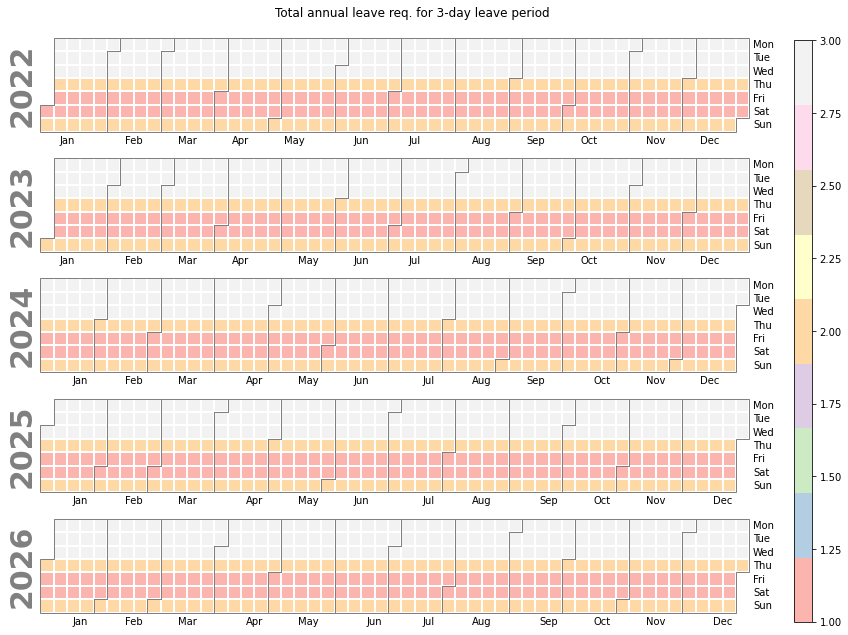

In [15]:
weekends_only(3)

Above shows a calender heatmap of the amount of days you are required to take for a 3-day leave period assuming no public holidays. 

It is recommended that you take leave between Thursday-Sunday for maximum effect.

(<Figure size 900x612 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c4b2e7690>,
       dtype=object))

<Figure size 7200x7200 with 0 Axes>

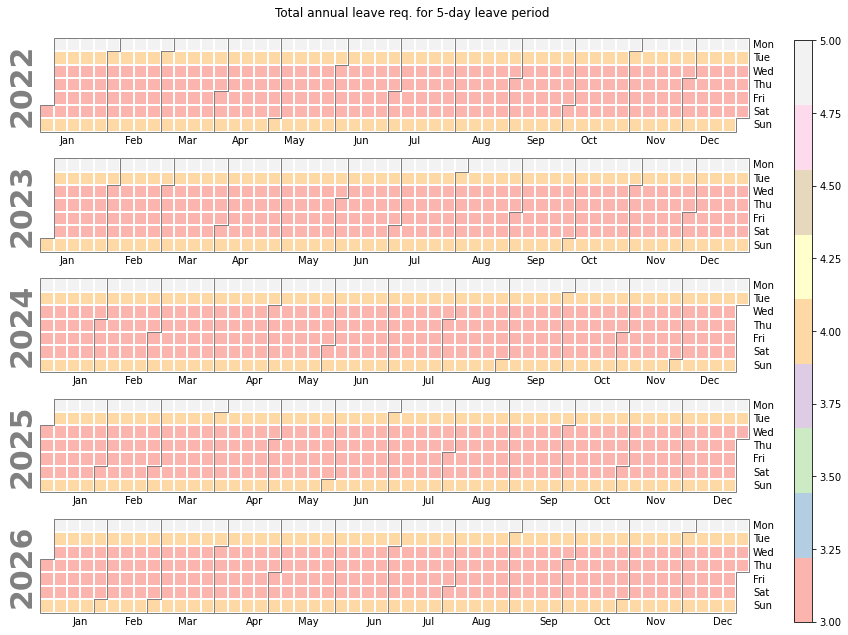

In [16]:
weekends_only(5)

Above shows a calender heatmap of the amount of days you are required to take for a 5-day leave period assuming no public holidays. 

It is recommended that you take leave between Wednesday-Friday for maximum effect.

### Public Holidays + Weekends

Three leave periods were considered:

1. 3-day leave period
2. 5 day leave period

As aforementioned, when looking at a date block, it shows the total annual leave required for the respective leave period. the subject date block is inclusive within the leave period.


In [17]:
def public_holi_Weekend(day):

  # #functions used for determining 
  annual_leave_period = day # days
  # interval_end_day = yr_start_date  + timedelta(days = day_interval - 1)

  #For dataframe
  total_cnt = []

  first_day = f"{year_start}-01-01"
  last_day = f"{year_end}-12-31"
  last_day = datetime.datetime.strptime(last_day, '%Y-%m-%d').date()

  #Create dataframe
  df = pd.DataFrame({"date": pd.date_range(first_day, last_day)})

  for date in df["date"].astype(str):
      
    #convert date into datetime format
    date = datetime.datetime.strptime(date, '%Y-%m-%d').date()

    interval_end_day = date  + timedelta(days = annual_leave_period-1)

    if  interval_end_day <= last_day:

      #we use DISTINCT function as holidays can occur on the same day
      c.execute('''
                SELECT DISTINCT datetable.date
                FROM datetable
                LEFT JOIN holiday
                ON datetable.date = holiday.date
                WHERE datetable.date BETWEEN ? and ?
                AND (holiday.type = "National holiday" OR datetable.weekday_type = "Weekend")                       
                ''',(str(date), str(interval_end_day),))
    
      a = c.fetchall()
      
      total_cnt.append(day-len(a))

    else:
      '''
      Req. so lists are same length
      But won't count cause we will be shortening it later
      '''
      total_cnt.append(0)

  # Adds to dataframe
  df['Count'] = total_cnt

  #Cuts out one year
  df = df[df["date"].astype(str) < str(year_end)]

  # Prep for graph 
  events = pd.Series(df[df.columns[1]].tolist(), index=df["date"])

  #plot graph
  fig = plt.figure( )
  fig = calplot.calplot(events,
                  colorbar = True,
                  cmap='Pastel1',
                  # tight_layout=False,
                  suptitle = f"Total annual leave req. for {day}-day leave period"
                  )
  
  return fig

(<Figure size 900x612 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c4b087b90>,
       dtype=object))

<Figure size 432x288 with 0 Axes>

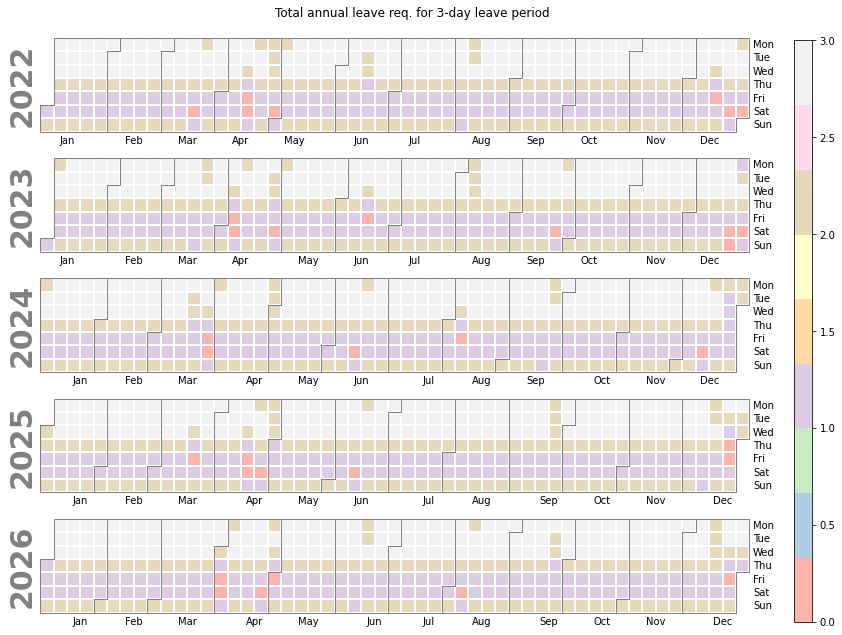

In [18]:
public_holi_Weekend(3)

Above shows a calender heatmap of the amount of days you may deduce your annual leave by for a 3-day leave period based on weekends and public holidays

Generally, best times to take leave is either Friday or Saturday.

High concentration of leave deductions occur in the months of April and December

(<Figure size 900x612 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c4ad19ad0>,
       dtype=object))

<Figure size 432x288 with 0 Axes>

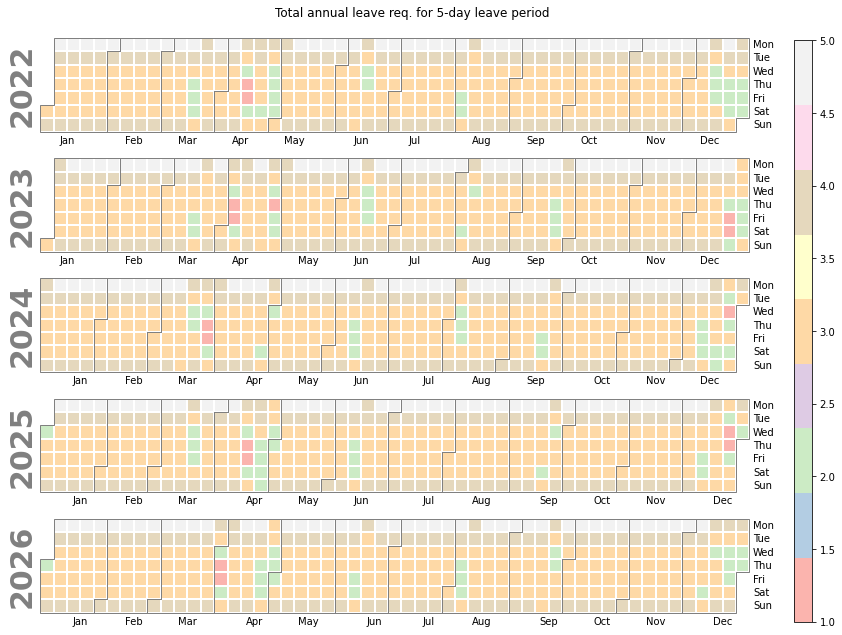

In [19]:
public_holi_Weekend(5)

(<Figure size 900x612 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c4ac02590>,
       dtype=object))

<Figure size 432x288 with 0 Axes>

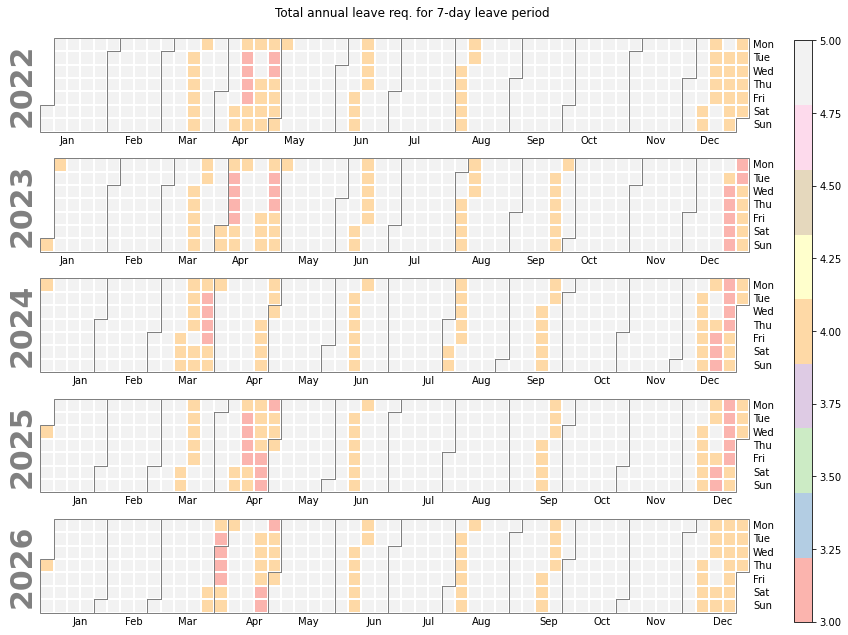

In [20]:
public_holi_Weekend(7)

Above shows a calender heatmap of the amount of days you may deduce your annual leave by for a 7-day leave period based on weekends and public holidays

High concentration of leave deductions occur in the months of March, April and December



# Special Calender Heatmap Visualisations

## Interactive Calender Heatmap 

This graph is similar to the graph above but it also hows one to hover over each block to view additional info (e.g. year, total leave-day deduction, date)

As of now, this cannot be seen directly on Github. The script needs to be downloaded and used thru Jupyter Notebook or Google Colab 

In [21]:
def public_holi_Weekend_interactive(day):

  # #functions used for determining 
  annual_leave_period = day # days

  #For dataframe
  total_cnt = []

  first_day = f"{year_start}-01-01"
  last_day = f"{year_end}-12-31"
  last_day = datetime.datetime.strptime(last_day, '%Y-%m-%d').date()

  #Create dataframe
  df = pd.DataFrame({"date": pd.date_range(first_day, last_day)})

  for date in df["date"].astype(str):
      
    #convert date into datetime format
    date = datetime.datetime.strptime(date, '%Y-%m-%d').date()

    interval_end_day = date  + timedelta(days = annual_leave_period-1)

    if  interval_end_day <= last_day:

      c.execute('''
                SELECT DISTINCT datetable.date
                FROM datetable
                LEFT JOIN holiday
                ON datetable.date = holiday.date
                WHERE datetable.date BETWEEN ? and ?
                AND (holiday.type = "National holiday" OR datetable.weekday_type = "Weekend")                       
                ''',(str(date), str(interval_end_day),))
    
      a = c.fetchall()
      
      total_cnt.append(day-len(a))

    else:
      '''
      Req. so lists are same length
      But won't count cause we will be shortening it later
      '''
      total_cnt.append(0)

  # Adds to dataframe
  df['Count'] = total_cnt

  #Cuts out last year
  df = df[df["date"].astype(str) < str(year_end)]

  # creating the plot
  from plotly_calplot import calplot
  fig = calplot(df, x = "date", y = "Count",
                month_lines_width=2,  
                month_lines_color="black",
                gap=1, 
                width = 1000,
                # total_height = 1100,
                title=f"Total annual leave req. for {day}-day leave period",
                years_title = True,
                space_between_plots = 0.06,
                colorscale="sunset"
                )
  return fig
  

In [22]:
public_holi_Weekend_interactive(5)

## July Package Calender Heatmap 

### July Calender Plot

this visualisation splits into each month. Number in each block shows total number of annual leave readuction. Note the heatmap range is dependent on the month. Therefore, The colours do not mean the same for each month

In [23]:
def calender_holi_july(day):

  import july
  from july.utils import date_range

  annual_leave_period = day # days

  #For dataframe
  total_cnt = []

  first_day = f"{year_start}-01-01"
  last_day = f"{year_start+1}-12-31"
  last_day = datetime.datetime.strptime(last_day, '%Y-%m-%d').date()

  #Create dataframe
  df = pd.DataFrame({"date": pd.date_range(first_day, last_day)})

  for date in df["date"].astype(str):
      
    #convert date into datetime format
    date = datetime.datetime.strptime(date, '%Y-%m-%d').date()

    interval_end_day = date  + timedelta(days = annual_leave_period-1)

    if  interval_end_day <= last_day:

      c.execute('''
                SELECT DISTINCT datetable.date
                FROM datetable
                LEFT JOIN holiday
                ON datetable.date = holiday.date
                WHERE datetable.date BETWEEN ? and ?
                AND (holiday.type = "National holiday" OR datetable.weekday_type = "Weekend")                       
                ''',(str(date), str(interval_end_day),))
    
      a = c.fetchall()
      
      total_cnt.append(day-len(a))

    else:
      '''
      Req. so lists are same length
      But won't count cause we will be shortening it later
      '''
      total_cnt.append(0)

  #Creates year range
  dates = date_range(first_day , last_day)

  # Adds to dataframe
  df['Count'] = total_cnt

  #Cuts out last year to show only one year
  df = df[df["date"].astype(str) < str(year_start+1)]
  data = df['Count'].to_numpy()

  # Calendar plot. 
  fig = july.calendar_plot(dates, 
                    data,
                    title = True,
                    value_label = True,
                    # date_label = True,
                    )
  
  print("5-day annual leave")
  return fig

5-day annual leave


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c49ebeb90>,
      dtype=object)

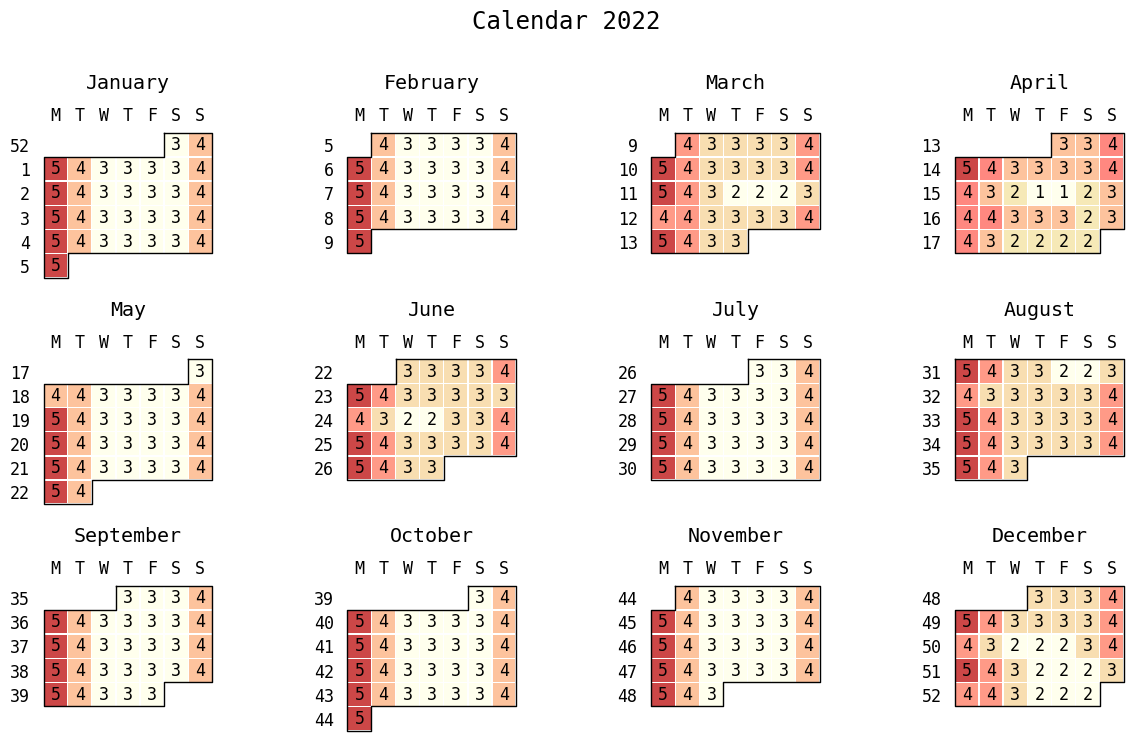

In [24]:
calender_holi_july(5)

### July Heatmap

In [25]:
def heatmap_holi_july(days):

  import july
  from july.utils import date_range

  annual_leave_period = days # days

  #For dataframe
  total_cnt = []

  first_day = f"{year_start}-01-01"
  last_day = f"{year_start+1}-12-31"
  last_day = datetime.datetime.strptime(last_day, '%Y-%m-%d').date()

  #Create dataframe
  df = pd.DataFrame({"date": pd.date_range(first_day, last_day)})

  for date in df["date"].astype(str):
      
    #convert date into datetime format
    date = datetime.datetime.strptime(date, '%Y-%m-%d').date()

    interval_end_day = date  + timedelta(days = annual_leave_period-1)

    if  interval_end_day <= last_day:

      c.execute('''
                SELECT DISTINCT datetable.date
                FROM datetable
                LEFT JOIN holiday
                ON datetable.date = holiday.date
                WHERE datetable.date BETWEEN ? and ?
                AND (holiday.type = "National holiday" OR datetable.weekday_type = "Weekend")                       
                ''',(str(date), str(interval_end_day),))
    
      a = c.fetchall()
      total_cnt.append(days-len(a))

    else:
      '''
      Req. so lists are same length
      But won't count cause we will be shortening it later
      '''
      total_cnt.append(0)

  #Creates year range
  dates = date_range(first_day , last_day)

  # Adds to dataframe
  df['Count'] = total_cnt

  #Cuts out last year to show only one year
  df = df[df["date"].astype(str) < str(year_start+1)]
  data = df['Count'].to_numpy()

  # Calendar plot. 

  fig = plt.figure(figsize=(1000,400))

  from typing import Union  
  fig = july.heatmap(dates=dates, 
                    data=data, 
                    #  Union[str, LinearSegmentedColormap, ListedColormap]
                    cmap='Pastel1',
                    month_grid=True, 
                    horizontal=True,
                    value_label=False,
                    date_label=True,
                    weekday_label=True,
                    month_label=True, 
                    year_label=True,
                    colorbar=True,
                    cmin = 0, 
                    cmax = days,
                    fontfamily="monospace",
                    fontsize=7,
                    title = f''' TOTAL ANNUAL REQ. FOR A {days}-DAY LEAVE PERIOD IN SOUTH AFRICA.\n
  Total Annual Leave Req. = Leave Period - Weekends - Public Holidays\n
  Block number rep. the day of the month.
  Block colour = total annual leave required for the respective leave period.
  The subject block is inclusive within the leave period. 
  Assume Saturday and Sunday count as non working days.\n
  e.g 1) 15-Apr requires {total_cnt[104]} annual leave days and the leave period is from 15-Apr to the {15+days-1}-Apr.
  e.g 2) 01-Jan requires {total_cnt[0]} annual leave days and the leave period is from 01-Jan to the {1+days-1}-Jan.
  e.g 3) 25 Dec requires {total_cnt[358]} annual leave days and the leave period is from 25-Dec to the {25+days-1}-Dec.

  NOTE: APPROVAL OF LEAVE NOT INCLUDED
                    ''',
                    titlesize ='large',
                    dpi=20)
  return fig

<Figure size 20000x8000 with 0 Axes>

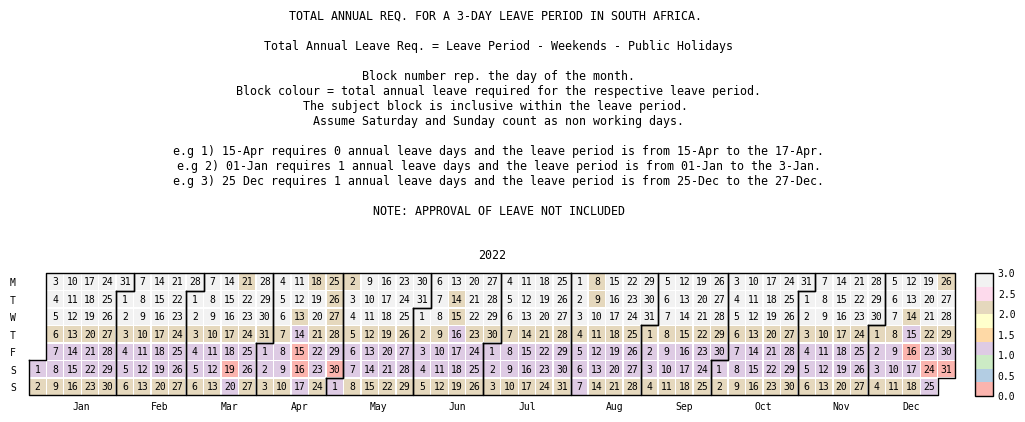

In [29]:
heatmap_holi_july(3)

<Figure size 20000x8000 with 0 Axes>

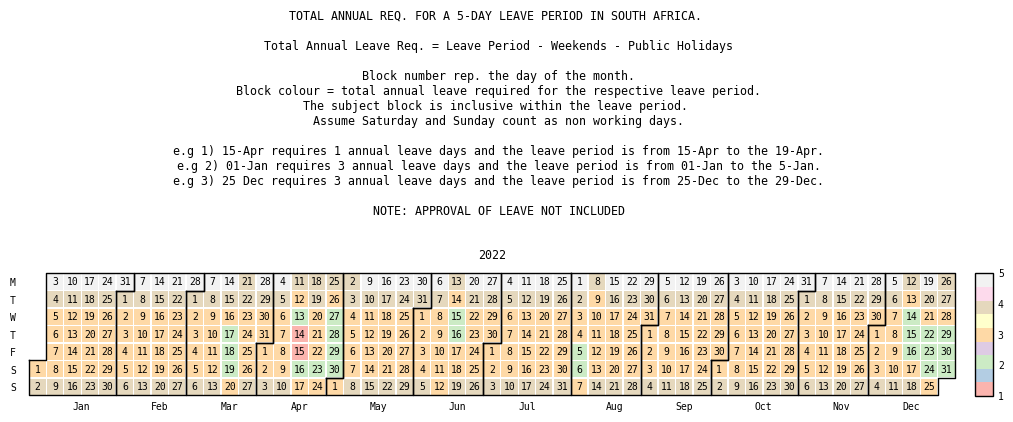

In [30]:
heatmap_holi_july(5)

<Figure size 20000x8000 with 0 Axes>

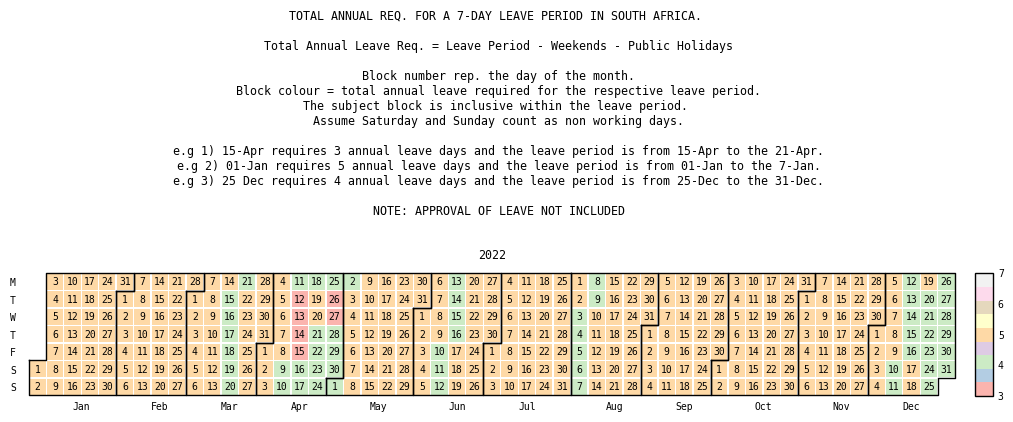

In [31]:
heatmap_holi_july(7)

# REFERENCES

##### Calenderific API Documentation
https://calendarific.com/api-documentation

##### Working with APIs
https://www.youtube.com/watch?v=hpc5jyVpUpw&list=LL&index=34

##### Convert pandas DataFrame into SQL in Python
https://www.geeksforgeeks.org/how-to-convert-pandas-dataframe-into-sql-in-python/

##### Change the Order of Columns in Pandas DataFrame
https://www.statology.org/pandas-change-column-order/

##### Convert Date String to Day of Week
https://stackoverflow.com/questions/16766643/convert-date-string-to-day-of-week

##### Pandas DataFrame to SQL
https://datatofish.com/pandas-dataframe-to-sql/

##### Get current date
https://www.delftstack.com/howto/python/python-current-year/

##### Simple plot with seaborn from a python dictionary
https://stackoverflow.com/questions/61852402/how-can-i-plot-a-simple-plot-with-seaborn-from-a-python-dictionary

##### Create a calendar table (date dimension) in pandas
https://stackoverflow.com/questions/47150709/how-to-create-a-calendar-table-date-dimension-in-pandas

##### convert pandas datetime to day, weekday, month
https://www.codegrepper.com/code-examples/python/df%5B%27weekday%27%5D+%3D+df%5B%27date%27%5D.dt.day_name%28%29

##### Python Check if Date is Weekend or Weekday

https://www.itsolutionstuff.com/post/python-check-if-date-is-weekend-or-weekday-exampleexample.html

##### SQL JOIN Tables
https://www.youtube.com/results?search_query=sql+join+tables

##### "Ambiguous Name Column” Error in SQL
https://towardsdatascience.com/how-to-solve-the-ambiguous-name-column-error-in-sql-d4c256f3d14c

##### Converting Date Difference to Integer 
https://stackoverflow.com/questions/53135789/convert-the-difference-between-two-dates-into-an-integer

##### Interactive Calendar Heatmaps with Python
https://python.plainenglish.io/interactive-calendar-heatmaps-with-plotly-the-easieast-way-youll-find-5fc322125db7

##### Continuous Color Scales and Color Bars in Python
https://plotly.com/python/colorscales/

##### SQL DISTINCT Function
https://stackoverflow.com/questions/57420931/how-to-write-a-sql-query-with-no-duplicates

##### July calender heatmap

https://pypi.org/project/july/

##### Convert pandas dataframe to NumPy array
https://stackoverflow.com/questions/13187778/convert-pandas-dataframe-to-numpy-array

#####  Duplicate Rows in SQL
https://learnsql.com/cookbook/how-to-find-duplicate-rows-in-sql/